In [0]:
# We should be in TensorFlow 2.0
%tensorflow_version 2.x

In [2]:
# Imports
from PIL import Image
import IPython.display as display
import pathlib
import tensorflow as tf

tf.__version__

'2.0.0'

In [0]:
# Get the flowers' dataset
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [4]:
!ls {flowers}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [5]:
# What got downloaded?
list_ds = tf.data.Dataset.list_files(str(pathlib.Path(flowers)/'*/*'))
for f in list_ds.take(5):
    print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/19613308325_a67792d889.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4746668678_0e2693b1b9_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/1667963621_c76d570af3_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/11746452_5bc1749a36.jpg'
b'/root/.keras/datasets/flower_photos/daisy/13826249325_f61cb15f86_n.jpg'


These are not strings, these are byte strings.

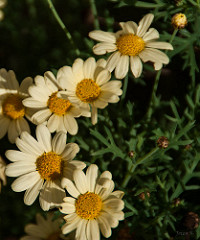

In [6]:
# Display a sample flower
filename="/root/.keras/datasets/flower_photos/daisy/14330343061_99478302d4_m.jpg"
display.display(display.Image(filename=filename))

### Creating a `TFRecord` of the above image

Reference: https://www.tensorflow.org/tutorials/load_data/tfrecord#walkthrough_reading_and_writing_image_data

In [0]:
# Using the above example
image_string = open(filename, 'rb').read()
label = b"daisy"

Images and strings are bytes and other useful features like dimensions of the image, number of channels are integers. 

In [0]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [0]:
# Create a dictionary with features that may be relevant
def image_example(image_string, label):
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _bytes_feature(label),
      'image_raw': _bytes_feature(image_string),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [0]:
# Writing the TFRecords
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [0]:
# Create a dictionary describing the features
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([],  tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

# Parse the input tf.Example proto using the dictionary above
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)


In [12]:
# Read images from the TFRecord
raw_image_dataset = tf.data.TFRecordDataset(record_file)
parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.string, width: tf.int64}>

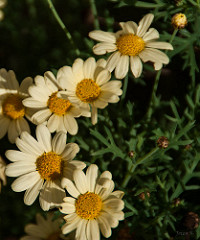

In [13]:
# Verify
for image_features in parsed_image_dataset:
    image_raw = image_features['image_raw'].numpy()
    display.display(display.Image(data=image_raw))